In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
df = pd.read_csv('/content/drive/MyDrive/TASK1/Startup_Scoring_Dataset.csv')


In [4]:
# Show basic info
print(df.shape)


(100, 7)


In [5]:
df.head()


,startup_id,team_experience,market_size_million_usd,monthly_active_users,monthly_burn_rate_inr,funds_raised_inr,valuation_inr
0,S001,7,789,66299,6091495,4183839,263247468
1,S002,4,939,34866,9106842,666326,172927107
2,S003,8,42,73630,8817088,649150,313090455
3,S004,5,57,93657,6374167,20153173,305887183
4,S005,7,512,61187,841971,118834,84815222


In [8]:
df.columns


Index(['startup_id', 'team_experience', 'market_size_million_usd',
       'monthly_active_users', 'monthly_burn_rate_inr', 'funds_raised_inr',
       'valuation_inr'],
      dtype='object')

In [7]:
from sklearn.preprocessing import MinMaxScaler


In [9]:
# Select columns to normalize
features = [
    'team_experience',
    'market_size_million_usd',
    'monthly_active_users',
    'monthly_burn_rate_inr',
    'funds_raised_inr'
]

# Initialize scaler
scaler = MinMaxScaler()

# Apply scaling
normalized_values = scaler.fit_transform(df[features])
normalized_df = pd.DataFrame(normalized_values, columns=[f + '_norm' for f in features])

# Invert burn rate (since higher is worse)
normalized_df['monthly_burn_rate_inr_norm'] = 1 - normalized_df['monthly_burn_rate_inr_norm']

# Combine with original DataFrame
df = pd.concat([df, normalized_df], axis=1)

# Preview results
df.head()


,startup_id,team_experience,market_size_million_usd,monthly_active_users,monthly_burn_rate_inr,funds_raised_inr,valuation_inr,team_experience_norm,market_size_million_usd_norm,monthly_active_users_norm,monthly_burn_rate_inr_norm,funds_raised_inr_norm
0,S001,7,789,66299,6091495,4183839,263247468,0.666667,0.789206,0.669162,0.393230,0.082061
1,S002,4,939,34866,9106842,666326,172927107,0.333333,0.941955,0.347274,0.084439,0.011052
2,S003,8,42,73630,8817088,649150,313090455,0.777778,0.028513,0.744235,0.114112,0.010706
3,S004,5,57,93657,6374167,20153173,305887183,0.444444,0.043788,0.949320,0.364283,0.404435
4,S005,7,512,61187,841971,118834,84815222,0.666667,0.507128,0.616813,0.930815,0.000000


In [10]:
# Define weights as fractions (total should equal 1)
weights = {
    'team_experience_norm': 0.15,
    'market_size_million_usd_norm': 0.25,
    'monthly_active_users_norm': 0.25,
    'funds_raised_inr_norm': 0.15,
    'monthly_burn_rate_inr_norm': 0.20  # already inverted
}

# Compute weighted score
df['startup_score'] = (
    df['team_experience_norm'] * weights['team_experience_norm'] +
    df['market_size_million_usd_norm'] * weights['market_size_million_usd_norm'] +
    df['monthly_active_users_norm'] * weights['monthly_active_users_norm'] +
    df['funds_raised_inr_norm'] * weights['funds_raised_inr_norm'] +
    df['monthly_burn_rate_inr_norm'] * weights['monthly_burn_rate_inr_norm']
) * 100  # to make score out of 100

# View result
df[['startup_id', 'startup_score']].head()


,startup_id,startup_score
0,S001,55.554705
1,S002,39.085300
2,S003,33.428186
3,S004,44.846554
4,S005,56.714832


In [11]:
# Rank startups by score
df = df.sort_values(by='startup_score', ascending=False).reset_index(drop=True)
df['rank'] = df.index + 1

# Top 10 performers
top_10 = df.head(10)
print("Top 10 Startups:")
print(top_10[['rank', 'startup_id', 'startup_score']])

# Bottom 10 performers
bottom_10 = df.tail(10)
print("\nBottom 10 Startups:")
print(bottom_10[['rank', 'startup_id', 'startup_score']])


Top 10 Startups:
   rank startup_id  startup_score
0     1       S006      83.546596
1     2       S013      78.711260
2     3       S035      78.577012
3     4       S073      77.889668
4     5       S077      75.791613
5     6       S033      75.537799
6     7       S085      75.110217
7     8       S050      74.479557
8     9       S082      72.012039
9    10       S036      71.020498

Bottom 10 Startups:
    rank startup_id  startup_score
90    91       S098      32.960725
91    92       S061      32.429973
92    93       S095      31.560942
93    94       S023      31.065320
94    95       S010      30.834992
95    96       S026      30.469310
96    97       S052      29.809975
97    98       S079      29.073945
98    99       S058      26.016813
99   100       S055      22.337173


In [12]:
# Example: Inspect a top scorer
df[df['startup_id'] == top_10.iloc[0]['startup_id']]



,startup_id,team_experience,market_size_million_usd,monthly_active_users,monthly_burn_rate_inr,funds_raised_inr,valuation_inr,team_experience_norm,market_size_million_usd_norm,monthly_active_users_norm,monthly_burn_rate_inr_norm,funds_raised_inr_norm,startup_score,rank
0,S006,10,416,95939,551157,48939582,307433345,1.0,0.409369,0.972689,0.960596,0.985549,83.546596,1


In [13]:
 #Example: Inspect a low scorer
df[df['startup_id'] == bottom_10.iloc[0]['startup_id']]


,startup_id,team_experience,market_size_million_usd,monthly_active_users,monthly_burn_rate_inr,funds_raised_inr,valuation_inr,team_experience_norm,market_size_million_usd_norm,monthly_active_users_norm,monthly_burn_rate_inr_norm,funds_raised_inr_norm,startup_score,rank
90,S098,7,234,4599,2553771,4466271,70995760,0.666667,0.224033,0.037326,0.755516,0.087762,32.960725,91


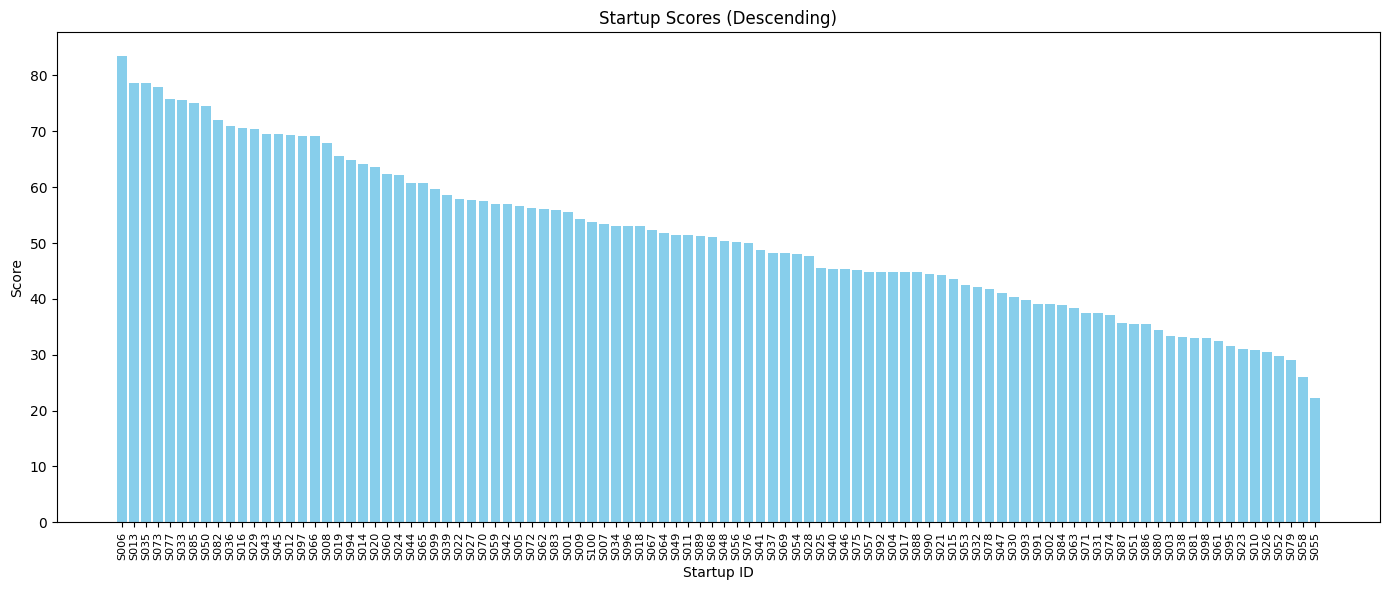

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
df_sorted = df.sort_values(by='startup_score', ascending=False)
plt.bar(df_sorted['startup_id'], df_sorted['startup_score'], color='skyblue')
plt.xticks(rotation=90, fontsize=8)
plt.title('Startup Scores (Descending)')
plt.xlabel('Startup ID')
plt.ylabel('Score')
plt.tight_layout()
plt.show()


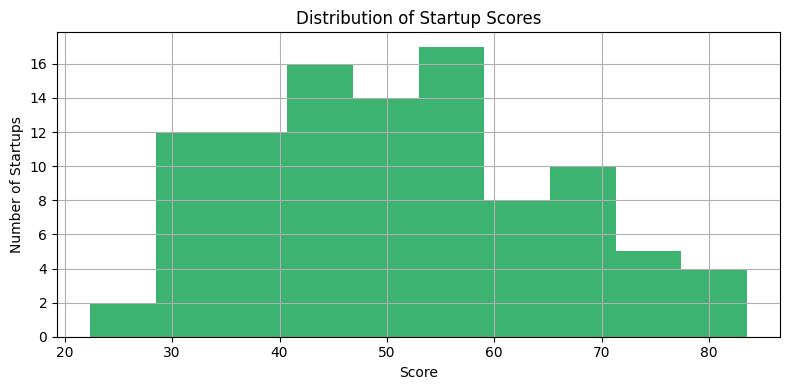

In [15]:
plt.figure(figsize=(8, 4))
plt.hist(df['startup_score'], bins=10, color='mediumseagreen')
plt.title('Distribution of Startup Scores')
plt.xlabel('Score')
plt.ylabel('Number of Startups')
plt.grid(True)
plt.tight_layout()
plt.show()


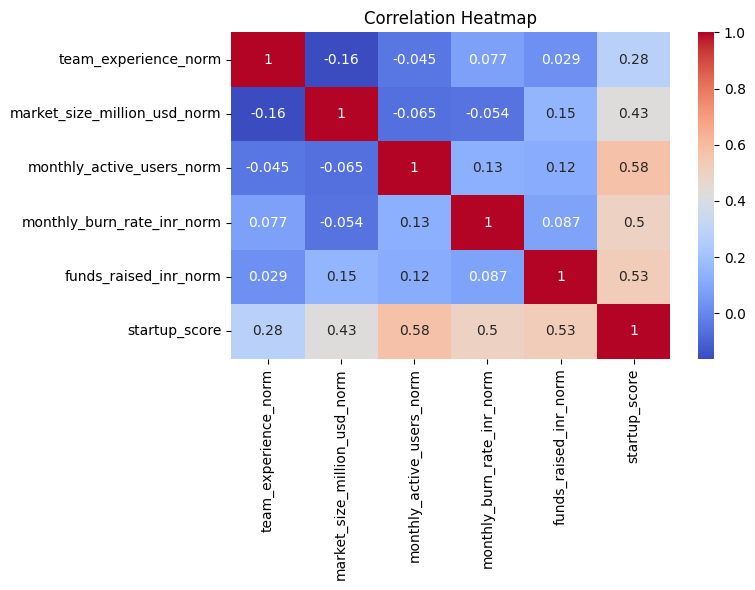

In [16]:
import seaborn as sns

plt.figure(figsize=(8, 6))
# Select only normalized columns + score
heatmap_data = df[[col for col in df.columns if '_norm' in col] + ['startup_score']]
sns.heatmap(heatmap_data.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()


In [17]:
plt.savefig('/content/drive/MyDrive/TASK1/score_bar_chart.png')


<Figure size 640x480 with 0 Axes>